(sec:cointoss)=
# Coin Toss

Imagine that we toss a coin multiple times and we would like to determine the probability to toss heads. Since this kind of random experiment has only two possible outcomes, the Bernoulli distribution $\text{B}(1, \theta)$ is an appropriate model. The multiple coin tosses yield a sequence of indepdent random experiments. Each coin toss corresponds to a random variable $X_i$ with value $1$ for heads and value $0$ for tails ($X_i$ represents the $i$-th toss). Hence, we aim to determine $\theta$. The sum $\sum_i^n X_i$ describes the number of heads after $n$ trials and has a binomial distribution $\text{B}(n, \theta)$.

Let us assume that **we doubt the fairness of the coin!**

First, we use the frequentists approach which is strongly connected to the law of large numbers and the central limit theorem. Since we think the coin is not fair, we claim $\theta \ne 0.5$.  

Typically, we assume the opposite of our claim, i.e., the so-called **null hypothesis**

$$H_0: \theta = 0.5$$

is assumed. The strategy is to find evidence that $H_0$ is most likely wrong such that it is reasonable to reject the null hypothesis. In this way, we can accept our actual claim. This procedure is called **hypothesis testing**.

For each $n \in \mathbb{N}$, the outcome of the average $\overline{X}_n := \frac{1}{n} \sum_i^n X_i$ can be calulated (the sample mean $\overline{x}_n$). Due to the law of large numbers, we expect that this value approaches $\theta$ for **large** values of $n$. In any case, our estimate for $\theta$ will differ at least slightly from the hypothesis $\theta = 0.5$. From our frequentists point of view, we have to decide whether this difference is small enough to support the hypothesis. *Maybe we should reject it*? Under the assumption $\theta=0.5$, we can approximate the distribution of $\overline{X}_n$ by a normal distribution due to the central limit theorem and calculate a bound for the probability to observe the difference of the average to $0.5$. The larger the difference the smaller the probability. This probability is called $p$**-value**. If the probability is smaller than a threshold of typically $5\%$ , $2\%$ or $1\%$ , $H_0$ is rejected. The correct interpretation is that our observation is not impossible if $\theta=0.5$, but rather unlikely. Hence, we tend to conclude that $\theta \ne 0.5$. The threshold is called **significance level** (denoted by $\alpha$). Note that the hypothesis test has a drawback: If e.g. $\alpha = 5\%$, the nullhypothesis will be rejected by mistake in $5\%$ of cases. This error is called **type I error**. At least, it is known how likely the **type I error** is and this error rate can be controlled by $\alpha$. A **type II error** is the mistaken acceptance of the null hypothesis. In this case, the error rate is usually hard to determine.

So, let's do the simulation:

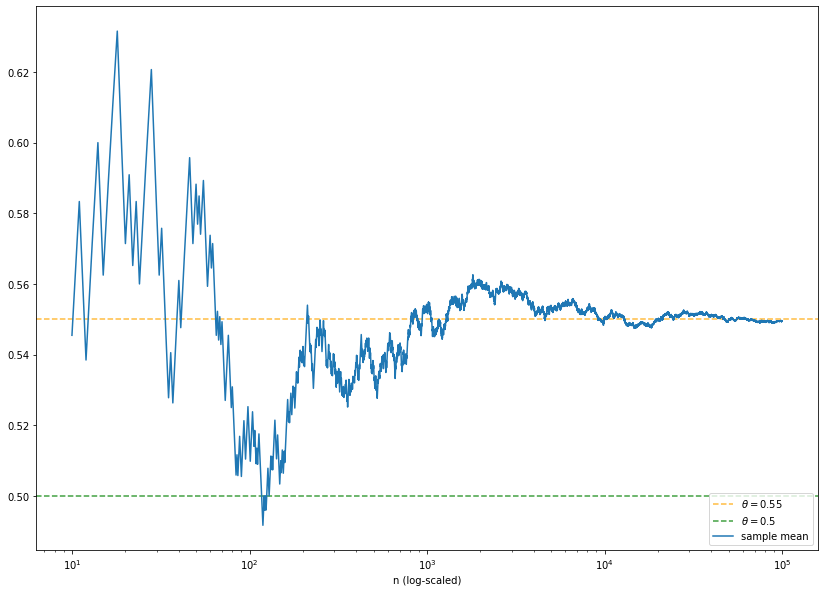

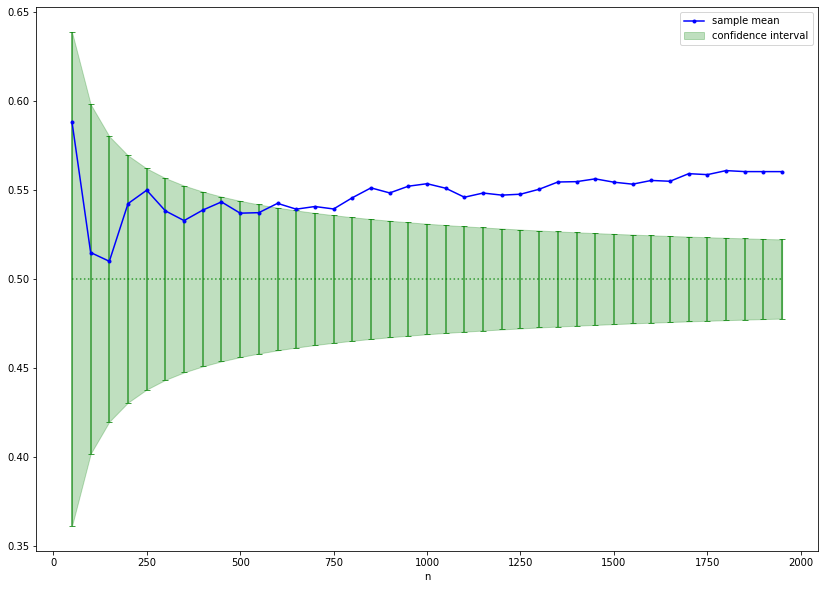

In [1]:
import numpy as np
from scipy.stats import bernoulli, norm
import matplotlib.pyplot as plt

N = 100000 # total number of coin tosses
theta = 0.55 # probability to toss heads ("unknown")
theta0 = 0.5 # probability assumed in the null hypothesis
alpha_sig = 0.05 # significance level

# generate N independent B(1, theta)-distributed observations
samples = bernoulli.rvs(theta, size=N)

# caluclate the sample means after n=1,...,N trials
sample_sums = np.zeros((N,)) # for later use
sample_means = np.zeros((N,))
for n in range(N):
    sample_sums[n] = np.sum(samples[:n+1])
    sample_means[n] = sample_sums[n]/(n + 1)

# plot the result
fig = plt.figure(figsize=(14, 10))
plt.axhline(y=theta, color='orange', linestyle='--', alpha=.75, label=r'$\theta=${}'.format(theta))
plt.axhline(y=theta0, color='g', linestyle='--', alpha=.75, label=r'$\theta=${}'.format(theta0))
plt.xscale('log')
plt.xlabel('n (log-scaled)')
plt.plot(np.arange(10, N), sample_means[10:], label='sample mean')
leg = plt.legend(loc='lower right')

# perform the hypothesis test for selected values of n
n_values = np.arange(50, 2000, step=50)
n_tests = len(n_values)
upper_bounds = np.zeros(n_tests)
lower_bounds = np.zeros(n_tests)
for i, n in enumerate(n_values):
    sigma2 = theta0*(1-theta0)/n # variance of sample mean under H0
    upper_bounds[i] = norm.ppf(1-alpha_sig/2, loc=theta0, scale=np.sqrt(sigma2)) # upper bound of confidence interval
    lower_bounds[i] = 2*theta0 - upper_bounds[i] # lower bound of confidence interval

# plot the result
fig = plt.figure(figsize=(14, 10))
plt.errorbar(n_values, theta0*np.ones(n_tests), yerr=(upper_bounds - theta0),
             c='g', alpha=.75, fmt=':', capsize=3, capthick=1)
plt.fill_between(n_values, lower_bounds, upper_bounds, color='g', alpha=.25, label='confidence interval')
plt.xlabel('n')
plt.plot(n_values, sample_means[n_values], marker='.', c='b', label='sample mean')
leg = plt.legend()

The confidence interval (green) illustrates the area around $\theta=0.5$ such that the outcome of $\overline{X}_n$ is inside the interval with probability $1- \alpha$ **supposed that** $0.5$ **is the true value**. If the sample mean (blue) is outside the confidence interval, the null hypothesis is rejected. Be careful! The interpretation that the true value of $\theta$ is inside the confidence inerval with probability $1- \alpha$ is **wrong**. In the frequentist setting the **true value is either in the interval or it is not**. This is not a question of probabilities. We can only be confident (up to some uncertainty given by $\alpha$) that the interval contains the outcome of $\overline{X}_n$ under the assumption $\theta=0.5$. This can be verified by simulating repeatedly a fixed number of tosses of a fair coin. In the long run, the sample mean should be inside the confidence interval in $1- \alpha$ percent of the cases. This fact is nicely illustrated by an interactive visualization by Kristoffer Magnusson (please click on the image to follow the link):

<a href="https://rpsychologist.com/d3/ci/"> <center><img src="CIanim.gif"></center></a>

Now, we analyze the problem the Bayesian way:

First, we include our prior beliefs on the value of $\theta$. For this purpose, we assign a probability distribution to $\theta$. Since $\theta$ is itself a probability, the distribution should have support on $[0, 1]$. A good choice is the beta distribution $\text{Beta}(\alpha, \beta)$. Suppose that we belief that our expectation is that $\theta$ is near $0.5$, but smaller or larger values are equally likely. Then, $\alpha = \beta = 2$ is an appropiate choice and the prior distribution density looks like this:

![](beta_pdf.png)


Now, we do Bayesian inference. The goal is to update the distribution of $\theta$ in use of observations. Instead of the sample mean $\overline{x}_n$, we use the sample sum $s_n$, since $\sum_i^n X_i$ is $\text{B}(n, \theta)$-distributed. By Bayes' theorem, it holds

$$p(\theta~|~s_n) = \frac{p(s_n~|~\theta)~ p(\theta)}{p(s_n)}$$

The so-called **evidence** $p(s_n)$ is independent of $\theta$ and a normalization term which ensures that the righthand side is again a probability distribution.

$p(\theta)$ is given by the **prior distribution**, i.e, 

$$p(\theta) = \frac{\theta^{\alpha -1} (1-\theta)^{\beta -1}}{\text{B}(\alpha, \beta)} = 6 \theta (1-\theta) \quad \text{for } \theta \in [0, 1],$$

since we use $\text{Beta}(2, 2)$ as prior distribution.

$p(s_n~|~\theta)$ is called **likelihood** and is $\text{B}(n, \theta)$-distributed. Therefore, it holds

$$p(s_n~|~\theta) = {{n}\choose{s_n}} \theta^{s_n} (1-\theta)^{n-s_n} \quad \text{for } \theta \in [0, 1].$$

Consequently, it follows

$$p(s_n~|~\theta)~ p(\theta) = {{n}\choose{s_n}} \theta^{s_n} (1-\theta)^{n-s_n} \frac{\theta^{\alpha -1} (1-\theta)^{\beta -1}}{\text{B}(\alpha, \beta)} = C ~ \theta^{\alpha + s_n - 1} (1-\theta)^{\beta + n-s_n -1},$$

where $C$ is some constant (independent of $\theta$). This shows that the **posterior distribution** $p(\theta~|~s_n)$ is again a beta distribution. More precisely, it is $\text{Beta}(\alpha + s_n, \beta + n - s_n)$-distributed. The observations yield an update of the distribution of $\theta$, but it is always from the family of beta distributions. Note that $\alpha$ and $\beta$ (the choice of the prior) get less and less important as $n$ increases.

The beta distribution is also called **conjugate prior** of the binomial distribution, since a beta distributed prior in combination with a binomial distributed likelihood yields a beta distributed posterior. This property enables sequential Bayesian inference, i.e., the posterior distribution can be used as prior distribution in the next inference step. 

Let's do the simulation:

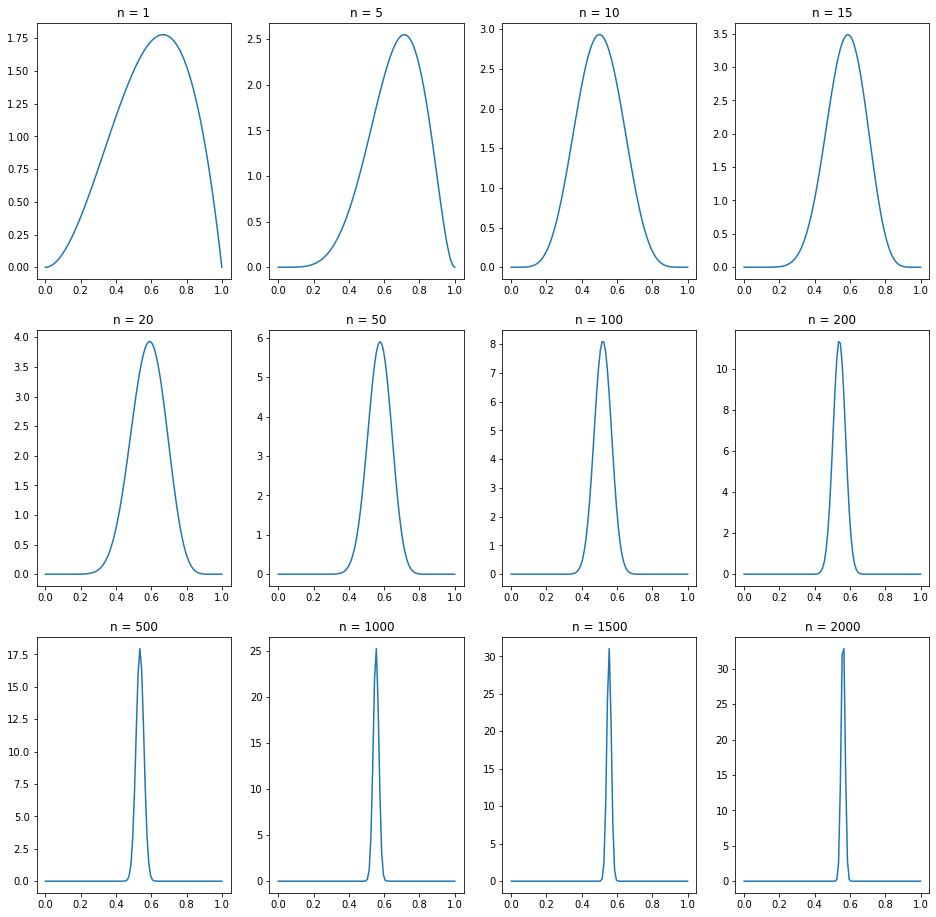

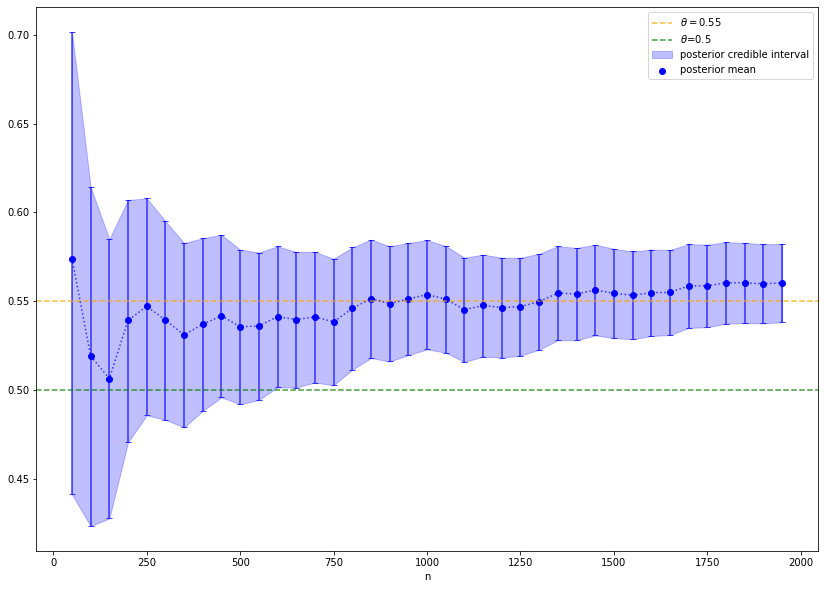

In [2]:
import numpy as np
from scipy.stats import beta as beta_distr
import matplotlib.pyplot as plt

alpha = 2 # alpha of prior distribution
beta  = 2 # beta of prior distribution

# use data (sample_sums) from first simulation
alphas = alpha + sample_sums # alpha values of posteriors
betas  = beta + np.arange(1, N+1) - sample_sums # beta values of posteriors 

# plot results for selected values of n
n_values = [1, 5, 10, 15, 20, 50, 100, 200, 500, 1000, 1500, 2000]

x = np.linspace(0, 1, num=100)
fig = plt.figure(figsize=(16, 16))
for i, n in enumerate(n_values):
    ax = fig.add_subplot(3, 4, i+1)
    ax.plot(x, beta_distr.pdf(x, alphas[n-1], betas[n-1]))
    ax.title.set_text('n = {}'.format(n))

# compute confidence bounds of posterior distributions
n_values = np.arange(50, 2000, step=50)
n_tests = len(n_values)
posterior_means = np.array([alphas[n-1]/(alphas[n-1] + betas[n-1]) for n in n_values])
posterior_modes = np.array([(alphas[n-1] -1)/(alphas[n-1] + betas[n-1] - 2) for n in n_values])
lower_errors = []
upper_errors = []
for i, n in enumerate(n_values):
    lower_errors.append(posterior_means[i] - beta_distr.ppf(alpha_sig/2, a=alphas[n-1], b=betas[n-1]))
    upper_errors.append(beta_distr.ppf(1-alpha_sig/2, a=alphas[n-1], b=betas[n-1]) - posterior_means[i])

# plot results
fig = plt.figure(figsize=(14, 10))
plt.errorbar(n_values, posterior_means, np.array(list(zip(lower_errors, upper_errors))).T, 
             c='b', alpha=.75, fmt=':', capsize=3, capthick=1)
plt.fill_between(n_values, posterior_means - np.array(lower_errors), posterior_means + np.array(upper_errors), 
                 color='b', alpha=.25, label='posterior credible interval')
plt.scatter(n_values, posterior_means, c='b', label='posterior mean')
# plt.scatter(n_values, posterior_modes, label='posterior mode')
plt.axhline(y=theta, color='orange', linestyle='--', alpha=.75, label=r'$\theta=${}'.format(theta))
plt.axhline(y=theta0, color='g', linestyle='--', alpha=.75, label=r'$\theta$={}'.format(theta0))
plt.xlabel('n')
leg = plt.legend()
    

This approach yields the same conclusion: the coin is likely biased. Nevertheless, the way of thinking is different. In the first simulation, we supposed that it exist a *true* probability $\theta$ for heads and came to the conclusion that $\theta=0.5$ is an unlikely hypothesis and therefore, the hypothesis is rejected. In the second simulation, we **do not prove a hypothesis true or false**. Each value of $\theta$ is still possible, but the posterior distributions shows that it is very likely to have a value larger than $0.5$. In particular, it is possible to calculate probabilities with respect to the posterior distribution of $\theta$. For example, in the above plot the value of $\theta$ is in the so-called credible interval (blue) with probability $1 - \alpha$. The Bayesian approach justifies to say that $\theta$ is in the credible interval with a certain probability, since the probability reflects our beliefs on the value of $\theta$.